In [1]:
import warnings
from pathlib import Path
import os
import pandas as pd
import tqdm
import random
import pickle

import socceraction.spadl as spadl
import socceraction.atomic.spadl as atomicspadl
import socceraction.atomic.vaep.features as fs
import socceraction.atomic.vaep.labels as lab
import socceraction.atomic.vaep.formula as vaepformula
from socceraction.spadl.wyscout import convert_to_actions
from socceraction.data.wyscout import PublicWyscoutLoader

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as logistic
from sklearn.ensemble import RandomForestClassifier as rfc
from catboost import CatBoostClassifier 
from xgboost import XGBClassifier as XGBc
from sklearn.metrics import brier_score_loss, roc_auc_score, log_loss

# Preprocessing

In [2]:
wyscout = PublicWyscoutLoader(root = '/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/data', download=False)

In [3]:
competitions = wyscout.competitions()
competitions.info()

<class 'pandera.typing.pandas.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   competition_id      7 non-null      int64 
 1   season_id           7 non-null      int64 
 2   country_name        7 non-null      object
 3   competition_name    7 non-null      object
 4   competition_gender  7 non-null      object
 5   season_name         7 non-null      object
dtypes: int64(2), object(4)
memory usage: 464.0+ bytes


In [4]:
comp = ['France']
selected_competitions = competitions[(competitions['country_name'] =='France')]
selected_competitions

,competition_id,season_id,country_name,competition_name,competition_gender,season_name
3,412,181189,France,French first division,male,2017/2018


# Retrieve scoreline of a game

In [5]:
dfs_matches = []
#Retrieve matches of a selected competition
for competition in comp:
    competition_name = competition
    file_matches = f'matches_{competition_name}.json'
    df_matches = pd.read_json('/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/Data/' + file_matches)
    dfs_matches.append(df_matches)
    
#Create a unique dataframe containing all the selected games
df_matches = pd.concat(dfs_matches)
df_matches.reset_index(drop = True, inplace = True)
df_matches.head(1)

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId
0,Played,4405655,38,"{'3783': {'scoreET': 0, 'coachId': 210513, 'si...",181189,2018-05-19 19:00:00,0,Stade Michel d'Ornano,2501056,"Caen - PSG, 0 - 0","May 19, 2018 at 9:00:00 PM GMT+2","[{'refereeId': 384954, 'role': 'referee'}, {'r...",Regular,412


In [6]:
#Extrapolate the scoreline of the game 
home_score, away_score = [],[]
for i in range(len(df_matches)) : 
    home_id, away_id = df_matches['teamsData'][i].keys()
    if df_matches['teamsData'][i][home_id]['side'] == 'away':
        home_id, away_id = away_id, home_id
    if df_matches['duration'][i] !='Regular':
        home_score.append(df_matches['teamsData'][i][home_id]['scoreET'])
        away_score.append(df_matches['teamsData'][i][away_id]['scoreET'])
    else:    
        home_score.append(df_matches['teamsData'][i][home_id]['score']+df_matches['teamsData'][i][home_id]['scoreET'])
        away_score.append(df_matches['teamsData'][i][away_id]['score']+df_matches['teamsData'][i][away_id]['scoreET'])

df_matches['home_score'] = home_score
df_matches['away_score'] = away_score
df_matches = df_matches[['seasonId','wyId','label','competitionId', 'home_score','away_score']]
df_matches.rename(columns={'seasonId':'season_id', 'wyId':'game_id','competitionId':'competition_id'}, inplace = True)

df_matches.head()

,season_id,game_id,label,competition_id,home_score,away_score
0,181189,2501056,"Caen - PSG, 0 - 0",412,0,0
1,181189,2501057,"Dijon - Angers SCO, 2 - 1",412,2,1
2,181189,2501058,"Olympique Lyonnais - Nice, 3 - 2",412,3,2
3,181189,2501059,"Olympique Marseille - Amiens SC, 2 - 1",412,2,1
4,181189,2501060,"Metz - Bordeaux, 0 - 4",412,0,4


In [7]:
# Get games  with goals from all selected competitions
games = pd.concat([wyscout.games(row.competition_id, row.season_id) for row in selected_competitions.itertuples()])

match_goals = pd.merge(games, df_matches, on =['game_id','competition_id','season_id'])
match_goals.drop(['label'],axis = 1, inplace = True)
games = match_goals

games.head()# Get games  with goals from all selected competitions
games = pd.concat([wyscout.games(row.competition_id, row.season_id) for row in selected_competitions.itertuples()])

match_goals = pd.merge(games, df_matches, on =['game_id','competition_id','season_id'])
match_goals.drop(['label'],axis = 1, inplace = True)
games = match_goals

games.head()

,game_id,competition_id,season_id,game_date,game_day,home_team_id,away_team_id,home_score,away_score
0,2501056,412,181189,2018-05-19 19:00:00,38,3783,3767,0,0
1,2501057,412,181189,2018-05-19 19:00:00,38,3804,3799,2,1
2,2501058,412,181189,2018-05-19 19:00:00,38,3766,3775,3,2
3,2501059,412,181189,2018-05-19 19:00:00,38,3771,3789,2,1
4,2501060,412,181189,2018-05-19 19:00:00,38,3777,3772,0,4


In [8]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380 entries, 0 to 379
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   game_id         380 non-null    int64         
 1   competition_id  380 non-null    int64         
 2   season_id       380 non-null    int64         
 3   game_date       380 non-null    datetime64[ns]
 4   game_day        380 non-null    int64         
 5   home_team_id    380 non-null    int64         
 6   away_team_id    380 non-null    int64         
 7   home_score      380 non-null    int64         
 8   away_score      380 non-null    int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 29.7 KB


# SPADL

In [9]:
#Store everything in the HDF
datafolder = "/Users/leonardoyang/Desktop/data-fifa/Fra"

In [11]:
#To upload the DF
spadl_h5 = os.path.join(datafolder, "atomic_spadl-wyscout.h5")

In [12]:
pd.HDFStore(spadl_h5)['teams'].reset_index().drop('index', axis =1)

,team_id,team_name_short,team_name
0,3783,Caen,Stade Malherbe Caen
1,3767,PSG,Paris Saint-Germain FC
2,3804,Dijon,Dijon FCO
3,3799,Angers,Angers SCO
4,3766,Olympique Lyonnais,Olympique Lyonnais
5,3775,Nice,O.G.C. Nice C\u00f4te d'Azur
6,3771,Olympique Marseille,Olympique de Marseille
7,3789,Amiens SC,Amiens SC
8,3772,Bordeaux,FC Girondins de Bordeaux
9,3777,Metz,FC Metz


In [13]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    # Select Psg vs Monaco
    game = games[(games.country_name == "France") 
                  & (games.home_team_name_short == "PSG")
                  & (games.away_team_name_short== "Monaco")]
    game_id = game.game_id.values[0]
    atomic_actions = spadlstore[f"actions/game_{game_id}"]
    atomic_actions = (
        atomic_actions
        .merge(atomicspadl.actiontypes_df(), how="left")
        .merge(spadl.bodyparts_df(), how="left")
        .merge(spadlstore["players"], how="left")
        .merge(spadlstore["teams"], how="left")
    )

# use nickname if available else use full name
atomic_actions["player_name"] = atomic_actions[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
del atomic_actions['nickname']
atomic_actions[:5]

,game_id,original_event_id,action_id,period_id,time_seconds,team_id,player_id,x,y,dx,dy,type_id,bodypart_id,type_name,bodypart_name,player_name,team_name_short,team_name
0,2501012,243285637,0,1,1.956679,19830,3450,52.50,33.32,5.25,-2.72,0,0,pass,foot,R. Falcao,Monaco,AS Monaco FC
1,2501012,243285637,1,1,3.370761,19830,28922,57.75,30.60,0.00,0.00,23,0,receival,foot,T. Lemar,Monaco,AS Monaco FC
2,2501012,243285639,2,1,4.784843,19830,28922,57.75,30.60,7.35,-10.20,0,0,pass,foot,T. Lemar,Monaco,AS Monaco FC
3,2501012,243285639,3,1,5.807595,19830,207143,65.10,20.40,0.00,0.00,23,0,receival,foot,Fabinho,Monaco,AS Monaco FC
4,2501012,243285640,4,1,6.830347,19830,207143,65.10,20.40,13.65,8.16,0,0,pass,foot,Fabinho,Monaco,AS Monaco FC


2018-04-15 19:00:00, Paris Saint-Germain FC - AS Monaco FC : 7-1 , Á. di María 20'


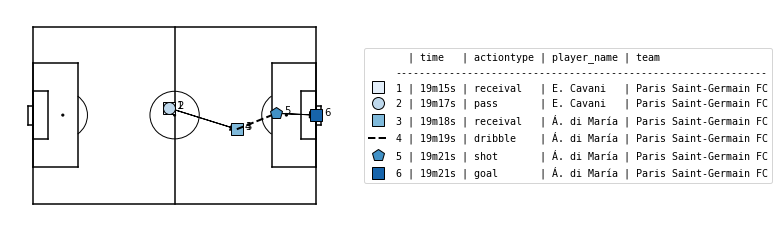

In [14]:
#select a goal to plot
import matplotsoccer

for shot in list(atomic_actions[(atomic_actions.type_name == "goal")][2:3].index):
    a = atomic_actions[shot-5:shot+1].copy()

    a["start_x"] = a.x
    a["start_y"] = a.y
    a["end_x"] = a.x + a.dx
    a["end_y"] = a.y + a.dy

    g = game.iloc[0]
    minute = int((a.period_id.values[0] - 1) * 45 + a.time_seconds.values[0] // 60)
    game_info = f"{g.game_date}, {g.home_team_name} - {g.away_team_name} : {g.home_score}-{g.away_score} , {a[-1:].player_name.values[0]} {minute + 1}'"
    print(game_info)

    def nice_time(row):
        minute = int((row.period_id-1) * 45 + row.time_seconds // 60)
        second = int(row.time_seconds % 60)
        return f"{minute}m{second}s"

    a["nice_time"] = a.apply(nice_time,axis=1)
    labels = a[["nice_time", "type_name", "player_name", "team_name"]]

    matplotsoccer.actions(
        location=a[["start_x", "start_y", "end_x", "end_y"]],
        action_type=a.type_name,
        team= a.team_name,
        label=labels,
        labeltitle=["time", "actiontype", "player_name", "team"],
        zoom=False,
        figsize=6
    )

## Compute features and labels

In [15]:
features_h5 = os.path.join(datafolder, "atomic_features.h5")
labels_h5 = os.path.join(datafolder, "atomic_labels.h5")

In [16]:
games = pd.HDFStore(spadl_h5)['games']
print("nb of games:", len(games))

nb of games: 380


In [17]:
#Example of final framework
print('Features')
display( pd.HDFStore(features_h5)["game_2501012"].head()) #With lags -1,-2.
print('Labels')
display(pd.HDFStore(labels_h5)["game_2501012"].head())

Features


,type_id_a0,type_id_a1,type_id_a2,type_pass_a0,type_cross_a0,type_throw_in_a0,type_freekick_crossed_a0,type_freekick_short_a0,type_corner_crossed_a0,type_corner_short_a0,...,time_seconds_a0,time_seconds_overall_a0,period_id_a1,time_seconds_a1,time_seconds_overall_a1,period_id_a2,time_seconds_a2,time_seconds_overall_a2,time_delta_1,time_delta_2
0,0,0,0,True,False,False,False,False,False,False,...,1.956679,1.956679,1,1.956679,1.956679,1,1.956679,1.956679,0.000000,0.000000
1,23,0,0,False,False,False,False,False,False,False,...,3.370761,3.370761,1,1.956679,1.956679,1,1.956679,1.956679,1.414082,1.414082
2,0,23,0,True,False,False,False,False,False,False,...,4.784843,4.784843,1,3.370761,3.370761,1,1.956679,1.956679,1.414082,2.828164
3,23,0,23,False,False,False,False,False,False,False,...,5.807595,5.807595,1,4.784843,4.784843,1,3.370761,3.370761,1.022752,2.436834
4,0,23,0,True,False,False,False,False,False,False,...,6.830347,6.830347,1,5.807595,5.807595,1,4.784843,4.784843,1.022752,2.045504


Labels


,scores,concedes,goal
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False


# Predictions

In [18]:
predictions_h5 = os.path.join(datafolder, "atomic-predictions-one-action.h5")

In [19]:
# 1. Select feature set X
xfns = [
    fs.actiontype_onehot,
    fs.bodypart_onehot,
    fs.goalscore,
    fs.location,
    fs.movement_polar,
    fs.polar,
    fs.direction,
    fs.team,
    fs.time,
    fs.time_delta
]
nb_prev_actions = 3

Xcols = fs.feature_column_names(xfns, nb_prev_actions)

def getXY(games, Xcols):
    # generate the columns of the selected feature
    X = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting features"):
        Xi = pd.HDFStore(features_h5) [f"game_{game_id}"]
        X.append(Xi[Xcols])
    X = pd.concat(X).reset_index(drop=True)

    # 2. Select label Y
    Ycols = ["scores", "concedes"]
    Y = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting label"):
        Yi = pd.HDFStore(labels_h5)[f"game_{game_id}"]
        Y.append(Yi[Ycols])
    Y = pd.concat(Y).reset_index(drop=True)
    return X, Y

In [20]:
### load model 
model = pickle.load(open('trained_model.sav', 'rb'))

In [21]:
#Prediction per tutte le partite
gamesX, gamesY = getXY(games,Xcols)
Y_hat = pd.DataFrame()
for col in gamesY.columns:
    Y_hat[col] = [p[1] for p in model[col].predict_proba(gamesX)]

Selecting label: 100%|██████████| 380/380 [00:03<00:00, 101.00it/s]


In [22]:
# get rows with game id per action
A = []
for game_id in tqdm.tqdm(games.game_id, "Loading actions of each game"):
    Ai = pd.HDFStore(spadl_h5) [f"actions/game_{game_id}"]
    A.append(Ai[["game_id"]])
A = pd.concat(A)
A = A.reset_index(drop=True)

# concatenate action game id rows with predictions and save per game
grouped_predictions = pd.concat([A, Y_hat], axis=1).groupby("game_id")
for k,df in tqdm.tqdm(grouped_predictions, desc="Saving predictions per game"):
    df = df.reset_index(drop=True)
    df[Y_hat.columns].to_hdf(predictions_h5, f"game_{int(k)}")

Saving predictions per game: 100%|██████████| 380/380 [00:09<00:00, 40.89it/s]


## VAEP

In [23]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    players = spadlstore["players"]
    teams = spadlstore["teams"]
print("nb of games:", len(games))

nb of games: 380


In [24]:
A = []
for game in tqdm.tqdm(list(games.itertuples()), desc="Loading actions"):
    actions = pd.HDFStore(spadl_h5) [f"actions/game_{game.game_id}"]
    actions = (
        atomicspadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left",)
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
    )
    preds = pd.HDFStore(predictions_h5) [f"game_{game.game_id}"]
    values = vaepformula.value(actions, preds.scores, preds.concedes)
    A.append(pd.concat([actions, preds, values], axis=1))
A = pd.concat(A).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)
A.columns

Loading actions: 100%|██████████| 380/380 [00:28<00:00, 13.41it/s]


Index(['game_id', 'original_event_id', 'action_id', 'period_id',
       'time_seconds', 'team_id', 'player_id', 'x', 'y', 'dx', 'dy', 'type_id',
       'bodypart_id', 'type_name', 'bodypart_name', 'player_name', 'nickname',
       'team_name_short', 'team_name', 'scores', 'concedes', 'offensive_value',
       'defensive_value', 'vaep_value'],
      dtype='object')

In [25]:
#Retrieve roles for each player
df_players = pd.read_json('/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/players.json')
df_players = df_players[['wyId','shortName','role','currentTeamId']]
Role = []
for i in range(len(df_players)):
    Role.append(df_players['role'][i]['name'])

df_players['Role'] = Role
df_players.drop('role', axis = 1,inplace = True)

In [26]:
A["count"] = 1
# Compute each player's number of actions and total VAEP values
playersR = (
    A[["player_id","vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)
#Add the last team for which the player has played
playersR = playersR.merge(A[["player_id","team_name_short"]].groupby('player_id').tail(1), on = 'player_id')
# Add player name
playersR = playersR.merge(players[["player_id", "nickname", "player_name"]], how="left")
playersR = pd.merge(playersR, df_players, left_on ='player_id', right_on = 'wyId', how = 'left').drop(['wyId','shortName'], axis = 1)
playersR["player_name"] = playersR[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
# Show results
playersR = playersR[["player_id", "player_name","Role", "team_name_short","vaep_value", "offensive_value", "defensive_value", "count"]]
playersR.sort_values("vaep_value", ascending=False)[:10]

,player_id,player_name,Role,team_name_short,vaep_value,offensive_value,defensive_value,count
43,21174,E. Cavani,Forward,PSG,34.643425,33.784658,0.858768,1402
259,40810,Neymar,Forward,PSG,33.743305,32.522101,1.221204,3553
108,25770,F. Thauvin,Forward,Olympique Marseille,29.699657,29.140942,0.558714,4621
179,26365,B. Reynet,Goalkeeper,Dijon,26.803125,2.421194,24.381932,2942
3,118,M. Depay,Forward,Olympique Lyonnais,26.233523,25.600764,0.632759,3280
53,25410,A. Pléa,Forward,Nice,25.433299,23.515702,1.917597,2751
217,28115,N. Fekir,Midfielder,Olympique Lyonnais,25.427441,24.905791,0.521650,3133
19,5167,Mariano Díaz,Forward,Olympique Lyonnais,23.823555,23.229194,0.594361,1411
201,26638,K. Toko Ekambi,Forward,Angers,22.409896,22.061070,0.348826,2611
196,26583,R. Gurtner,Goalkeeper,Amiens SC,22.046398,1.964710,20.081687,2107


In [27]:
# Normalize for minutes played
pg = pd.HDFStore(spadl_h5) ["player_games"]
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats.rename(columns={'team_name_short':'Team'}, inplace = True)
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_rating"] = stats.offensive_value * 90 / stats.minutes_played
stats["defensive_rating"] = stats.defensive_value * 90 / stats.minutes_played

In [28]:
#filename = 'players_fra.sav'
#pickle.dump(stats, open(filename, 'wb'))
stats = pickle.load(open('players_fra.sav', 'rb'))

In [29]:
stats = stats[stats.minutes_played > 1670] # at least 19 full games played
stats.sort_values("vaep_rating",ascending=False)[:10]

,player_id,player_name,Role,Team,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
258,40810,Neymar,Forward,PSG,33.743305,32.522101,1.221204,3553,1862,1.630987,1.571960,0.059027
42,21174,E. Cavani,Forward,PSG,34.643425,33.784658,0.858768,1402,2681,1.162965,1.134136,0.028828
2,118,M. Depay,Forward,Olympique Lyonnais,26.233523,25.600764,0.632759,3280,2671,0.883945,0.862624,0.021321
216,28115,N. Fekir,Midfielder,Olympique Lyonnais,25.427441,24.905791,0.521650,3133,2618,0.874129,0.856196,0.017933
107,25770,F. Thauvin,Forward,Olympique Marseille,29.699657,29.140942,0.558714,4621,3072,0.870107,0.853739,0.016369
473,353833,K. Mbappé,Forward,PSG,20.781155,20.249551,0.531604,2018,2255,0.829403,0.808186,0.021217
18,5167,Mariano Díaz,Forward,Olympique Lyonnais,23.823555,23.229194,0.594361,1411,2617,0.819305,0.798864,0.020440
13,3450,R. Falcao,Forward,Monaco,19.211458,18.988277,0.223181,1467,2212,0.781660,0.772579,0.009081
10,3314,Á. di María,Midfielder,PSG,17.896984,17.546573,0.350411,3006,2182,0.738189,0.723736,0.014453
386,256084,Kwon Chang-Hoon,Midfielder,Dijon,17.901105,16.615994,1.285111,1931,2239,0.719562,0.667905,0.051657


# Salary 

In [30]:
fra = pd.read_excel('/Users/leonardoyang/Desktop/Tesi/Data/ligue-1/2017-2018/all_ligue-1_2017-2018.xlsx')
fra = fra[fra['Annual Gross(IN EUR)']>0]
fra = fra.drop_duplicates(subset=["Player"], keep='last')
fra.drop('Unnamed: 0', axis = 1, inplace = True)

fra['Name'] = [fra['Player'][i-1:i].values[0].split()[0] for i in range(1,len(fra.Player)+1)]
fra['Surname'] = [fra['Player'][i-1:i].values[0].split()[-1] for i in range(1,len(fra.Player)+1)]

In [31]:
#Retrieve player full name and surname
players['Name'] =[players['player_name'][i-1:i].values[0].split()[0] for i in range(1,len(players.player_name)+1)]
players['Surname'] =[players['player_name'][i-1:i].values[0].split()[-1] for i in range(1,len(players.player_name)+1)]
giocatori = stats.merge(players, on = 'player_id').drop(['nickname'], axis = 1)
#giocatori = giocatori[giocatori['minutes_played']>1210]

#Merge players' stats and salary based on surname,name. Those players not matched due to language barriers were manually added by including their WyID in the salary data.
df = pd.merge(giocatori,fra, on = ['Name','Surname'], how = 'left').sort_values('Annual Gross(IN EUR)', ascending = False).rename(columns={'Annual Gross(IN EUR)':'Salary'})
df = df[['player_id','Player','Age','Role_x','Team_x','vaep_value','offensive_value','defensive_value','count','minutes_played','vaep_rating','Salary']]
missing = pd.merge(df,fra, left_on = 'player_id', right_on = 'ID')
missing = missing[['player_id','Player_y','Age_y','Role_x','Team_x','vaep_value','offensive_value','defensive_value','count','minutes_played','vaep_rating','Annual Gross(IN EUR)']]
missing.rename(columns={'Player_y':'Player','Age_y':'Age','Annual Gross(IN EUR)':'Salary'}, inplace = True)

df = pd.concat([df,missing]).rename(columns = {'Role_x':'Role','Team_x':'Team'}).reset_index(drop=True)
df = df.dropna().drop('player_id', axis = 1).drop_duplicates()
#Create VAEP/Salary
df['vaep/salary'] = df['vaep_value']*10**4/ df['Salary']
display(df[(df['Role']=='Defender')].sort_values('vaep/salary',ascending = False).groupby('Role').mean())
display(df[(df['Role']=='Forward')].sort_values('vaep/salary',ascending = False).groupby('Role').mean())

,Age,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,Salary,vaep/salary
Role,,,,,,,,,
Defender,25.987179,5.969231,3.117719,2.851512,3034.294872,2531.358974,0.214281,1.274269e+06,0.111522


,Age,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,Salary,vaep/salary
Role,,,,,,,,,
Forward,24.04878,13.894475,13.151785,0.74269,2162.219512,2393.317073,0.51962,3.161683e+06,0.134662


In [32]:
df.groupby('Role').agg(['mean']).iloc[:2][['vaep_value','Salary','vaep/salary']].round(4)

,vaep_value,Salary,vaep/salary
,mean,mean,mean
Role,,,
Defender,5.9692,1.274269e+06,0.1115
Forward,13.8945,3.161683e+06,0.1347


# Top11

In [33]:
gk = df[df['Role']=='Goalkeeper'].sort_values('vaep/salary',ascending = False)[:5]
dif = df[df['Role']=='Defender'].sort_values('vaep/salary',ascending = False)[:5]
cen = df[df['Role']=='Midfielder'].sort_values('vaep/salary',ascending = False)[:5]
att = df[df['Role']=='Forward'].sort_values('vaep/salary',ascending = False)[:5]

In [34]:
top_11 = gk.append(dif).append(cen).append(att)
#top_11['Salary'] = top_11['Salary'].astype(int).map('{:,}'.format)
top_11 = top_11[['Player','Age','Role','Team','vaep_rating','minutes_played','vaep_value','Salary','vaep/salary']]
top_11.loc[:,'vaep_rating':] = top_11.loc[:,'vaep_rating':].round(4)
order = ['Goalkeeper','Defender','Midfielder','Forward']
top_11["Role"] = pd.Categorical(top_11["Role"], categories=order, ordered=True)
n = {'Goalkeeper':1, 'Defender':4,'Midfielder':3, 'Forward':3}
top_11 = top_11.groupby('Role').apply(lambda x: x.sort_values("vaep_rating", ascending=False)).drop('Role', axis = 1).reset_index()
top_11 = top_11.groupby('Role').apply(lambda x: x.head(n[x.name])).drop('level_1', axis = 1).reset_index(drop=True)
top_11.index =top_11.index +1
top_11[['Player','Age','Role','Team','minutes_played','vaep_rating','vaep_value','Salary','vaep/salary']]

,Player,Age,Role,Team,minutes_played,vaep_rating,vaep_value,Salary,vaep/salary
1,Eiji Kawashima,34.0,Goalkeeper,Metz,2698,0.7007,21.0041,438000.0,0.4795
2,Lucas Lima,25.0,Defender,Nantes,2809,0.3434,10.7171,351000.0,0.3053
3,Jules Koundé,18.0,Defender,Bordeaux,1672,0.3141,5.8353,99000.0,0.5894
4,Nordi Mukiele,19.0,Defender,Montpellier,2944,0.2757,9.0192,355000.0,0.2541
5,Kelvin Amian,19.0,Defender,Toulouse,3333,0.1868,6.9175,215000.0,0.3217
6,Flavien Tait,24.0,Midfielder,Angers,2328,0.3944,10.2016,415000.0,0.2458
7,Stéphane Darbion,33.0,Midfielder,Troyes,1798,0.3860,7.7113,296000.0,0.2605
8,Dimitri Liénard,29.0,Midfielder,Strasbourg,2742,0.3373,10.2751,388000.0,0.2648
9,Karl Toko Ekambi,24.0,Forward,Angers,3196,0.6311,22.4099,652000.0,0.3437
10,Moussa Konaté,24.0,Forward,Amiens SC,2580,0.5441,15.5976,474000.0,0.3291


In [35]:
print("Average salary per Team(~starting 11)): ",('{:,}'.format(int(df.groupby('Team').sum()['Salary'].mean()))),"€")
print("Median salary per Team(~starting 11)): ",('{:,}'.format(int(df.groupby('Team').sum()['Salary'].median()))),"€")
print("Salary per Top_11: " + ('{:,}'.format(int(top_11.Salary.sum()))+ "€"))

Average salary per Team(~starting 11)):  17,736,350 €
Median salary per Team(~starting 11)):  7,169,000 €
Salary per Top_11: 4,038,000€
